## Assignment 2 - Continous Wavelet Decomposition

*   List item
*   List item


### Author: Luca Palumbo, 639750


Python's module used for the assignment:

In [ ]:
!pip install PyWavelets
import numpy as np
import csv
from matplotlib import pyplot as plt
from matplotlib import colors
import os
import pywt

Download the dataset if not present.

In [ ]:
dataset_path = "./dataset"
if not os.path.exists(dataset_path):
  !mkdir dataset
  !curl -L -o ./dataset/single-chestmounted-accelerometer.zip  https://www.kaggle.com/api/v1/datasets/download/imsparsh/single-chestmounted-accelerometer
  !unzip ./dataset/single-chestmounted-accelerometer.zip -d ./dataset
  !rm ./dataset/single-chestmounted-accelerometer.zip

Let's define some usefull variable.
- `file_name`: path to the file of one chosen partecipant.
- `sampling_frequency`: sampling frequency of the accelerometer used
- `activity_labels`: dictionary that associates activity ids to the activity names

In [ ]:
file_name = 'dataset/1.csv'
sampling_frequency = 52 # Hz
activity_labels = {
    'Working at Computer'                              : 1,
    'Standing Up, Walking and Going up\\down stairs'   : 2,
    'Standing'                                         : 3,
    'Walking'                                          : 4,
    'Going Up\\Down Stairs'                            : 5,
    'Walking and Talking with Someone'                 : 6,
    'Talking while Standing'                           : 7
}

The next function is used to read data from the dataset.

It get the .csv file as first parameter, the activity id (1-7) as second parameter and it returns a (3,N) shaped numpy array.

In [ ]:
def read_data(file_path: str, activity: int) -> np.ndarray:
    activity_data = [[], [], []] # x, y, z data
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            if row[4] == str(activity):
                x_accel = float(row[1])
                y_accel = float(row[2])
                z_accel = float(row[3])

                activity_data[0].append(x_accel)
                activity_data[1].append(y_accel)
                activity_data[2].append(z_accel)

        activity_data = np.array(activity_data)
    return activity_data

This code is used to visualize the 7 activities of one selected pertecipant:

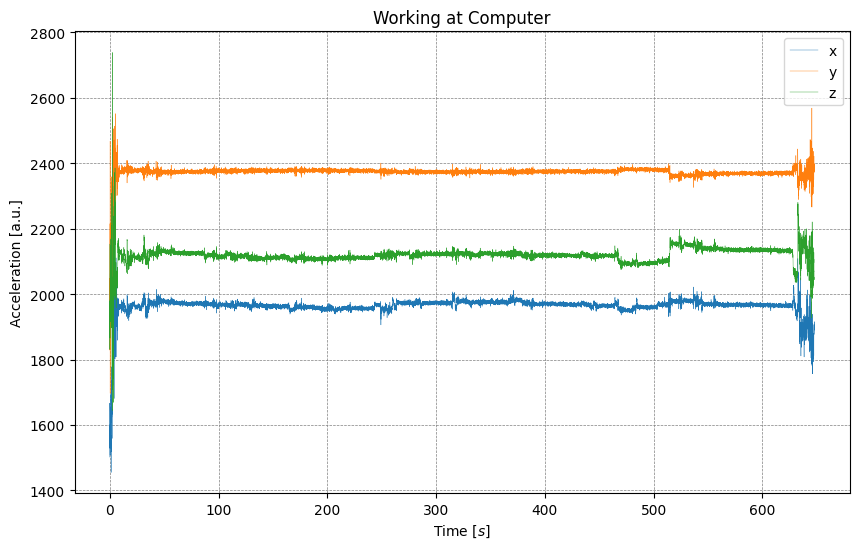

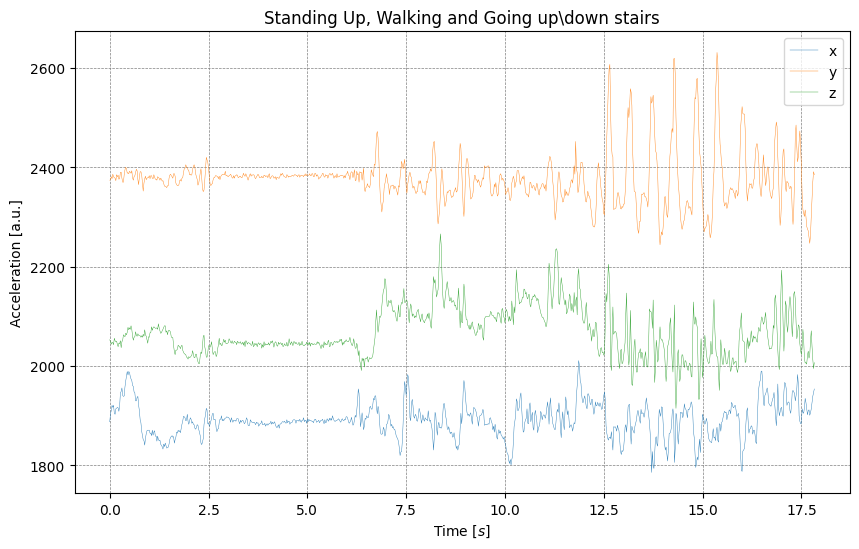

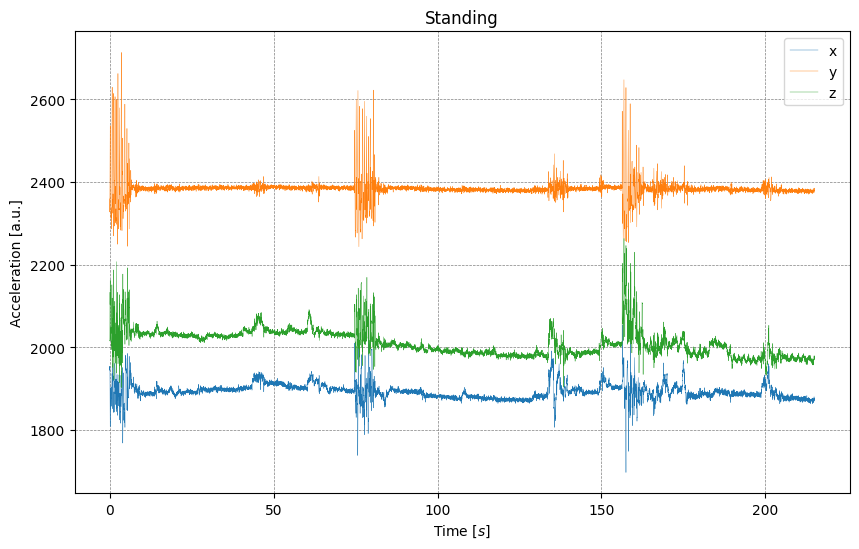

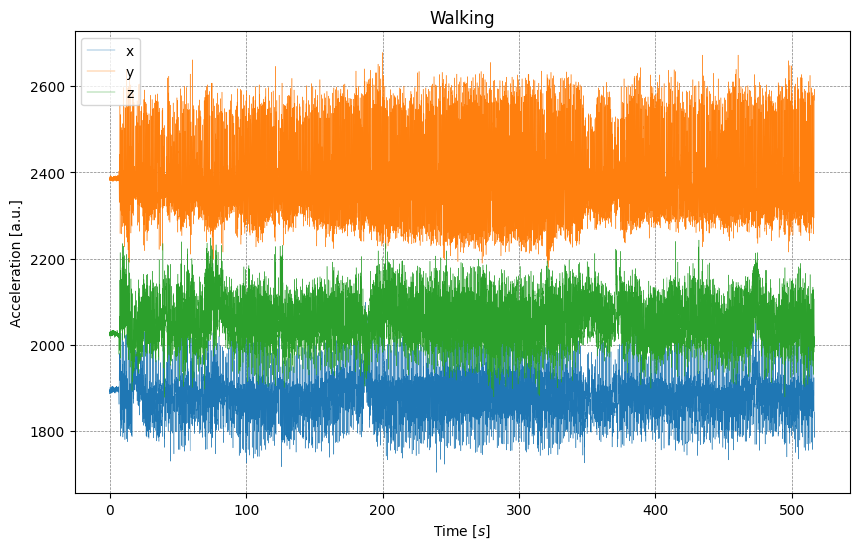

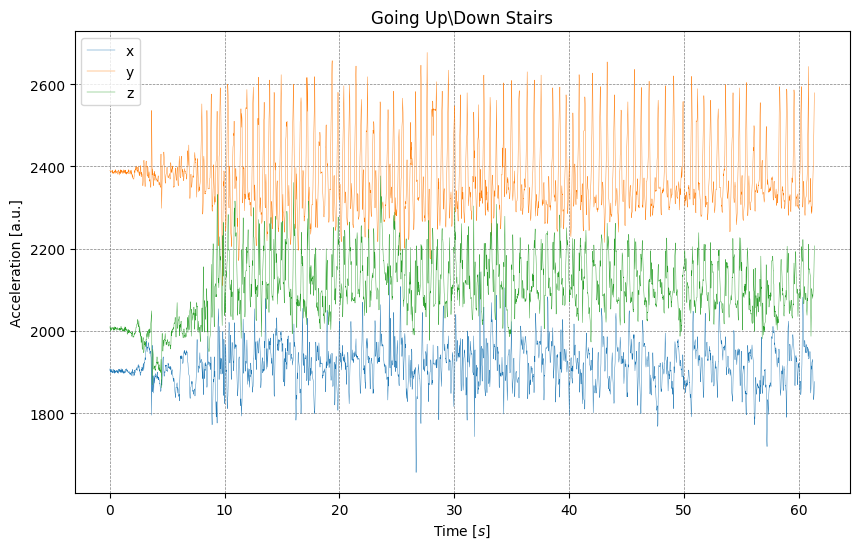

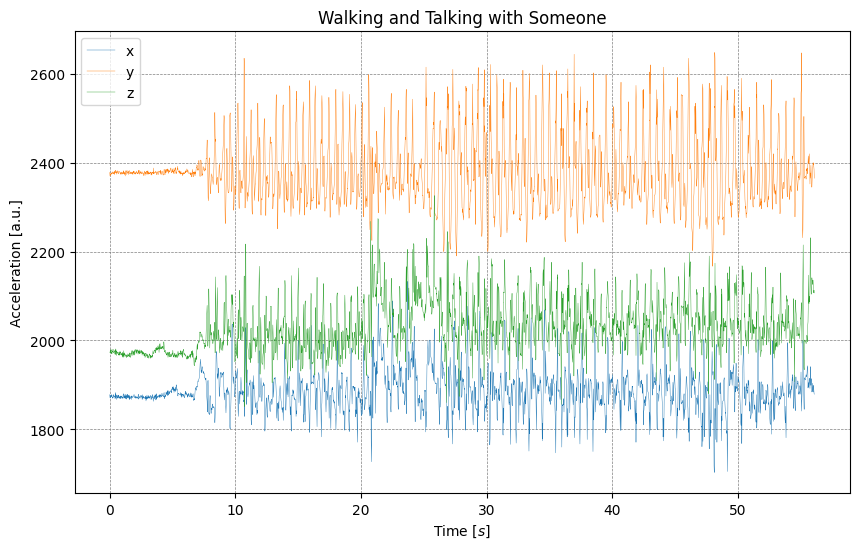

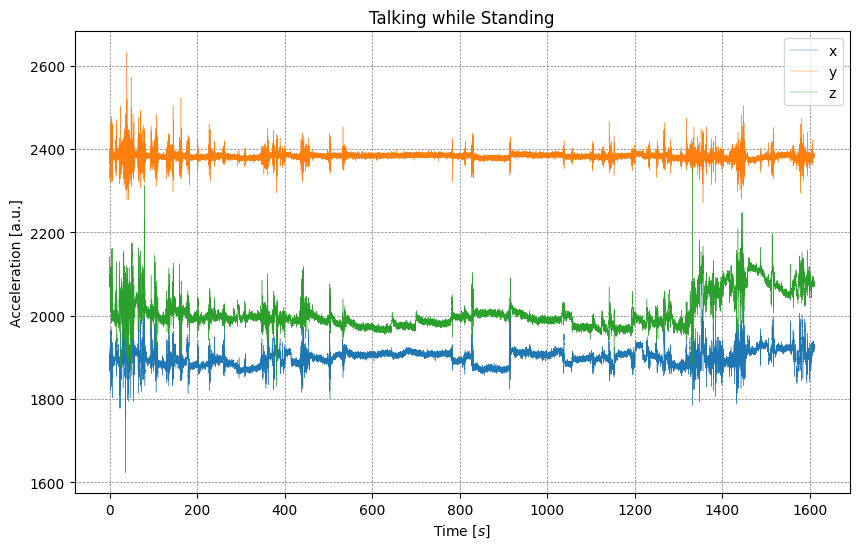

In [ ]:
def plot_data(activity_data: np.ndarray, title: str = 'Accelerometer Data'):
    x = np.arange(0, len(activity_data[0]), 1) * (1/sampling_frequency)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.title(title)
    plt.xlabel('Time [$s$]')
    plt.ylabel('Acceleration [a.u.]') # arbitrary units
    plt.plot(x, activity_data[0], label='x', linewidth=0.3)
    plt.plot(x, activity_data[1], label='y', linewidth=0.3)
    plt.plot(x, activity_data[2], label='z', linewidth=0.3)
    plt.legend()
    # fig size
    plt.gcf().set_size_inches(10, 6)
    plt.show()

for label, id in activity_labels.items() :
    data = read_data(file_name, activity=id)
    plot_data( data, label )

The next step is to perform the Continuous Wavelet Transform (CWT). For this purpose, I will use the `cwt` function from the pyWavelets library.

Below are the key choices made in this process:
- **Wavelet selection**: The Mexican hat wavelet was chosen without a specific reason.
- **Scale range**: The selected scales cover the frequency range $\omega \in (\omega_{sampling} / N,\omega_{sampling} / 2)$ where $N$ is the number of sampled data points in the signal. The upper bound is dictated by the Nyquist-Shannon sampling theorem, while the lower bound ensures that a signal at the corresponding frequency fits within the total sampling duration. The conversion from frequency to scale, given the chosen wavelet, is performed using the `frequency2scale` function. The scales were then sampled within this range, spaced evenly on a logarithmic scale.


**Note**: Before computing the CWT, I subtracted the mean value from the signal. This prevents the appearance of artificial peaks at low frequencies.


In [ ]:
def perform_cwt(activity_data: np.ndarray, title : str):
    axes_labels = ["X", "Y", "Z"]
    wavelet = "mexh"  # Others: "cmor2.5-1.5", "morl", "gaus5"

    maxScale = pywt.frequency2scale(wavelet, 1/len(activity_data[0]) )
    minScale = pywt.frequency2scale(wavelet, 1/2 )
    widths = np.geomspace(minScale, maxScale, num=100)  # Scales for the CWT

    fig, axes = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

    for i in range(3):
        data = activity_data[i] - np.mean(activity_data[i])  # remove DC component, prevents peaks at low frequencies

        # computes the CWT of the signal
        cwtmatr, freqs = pywt.cwt(data, widths, wavelet, sampling_period=1/sampling_frequency)
        cwtmatr = np.abs(cwtmatr[:-1, :-1])

        time = np.arange(0, len(data)) * (1/sampling_frequency)

        pcm = axes[i].pcolormesh(time, freqs, cwtmatr, cmap='viridis', shading='auto')
        axes[i].set_yscale("log")
        axes[i].set_ylabel("Frequency (Hz)")
        axes[i].set_title(f"CWT - {axes_labels[i]} axis - {title}")

    axes[-1].set_xlabel("Time (s)")

    cbar = fig.colorbar(pcm, ax=axes, orientation='vertical', label="CWT Magnitude", aspect=30)

    plt.show()


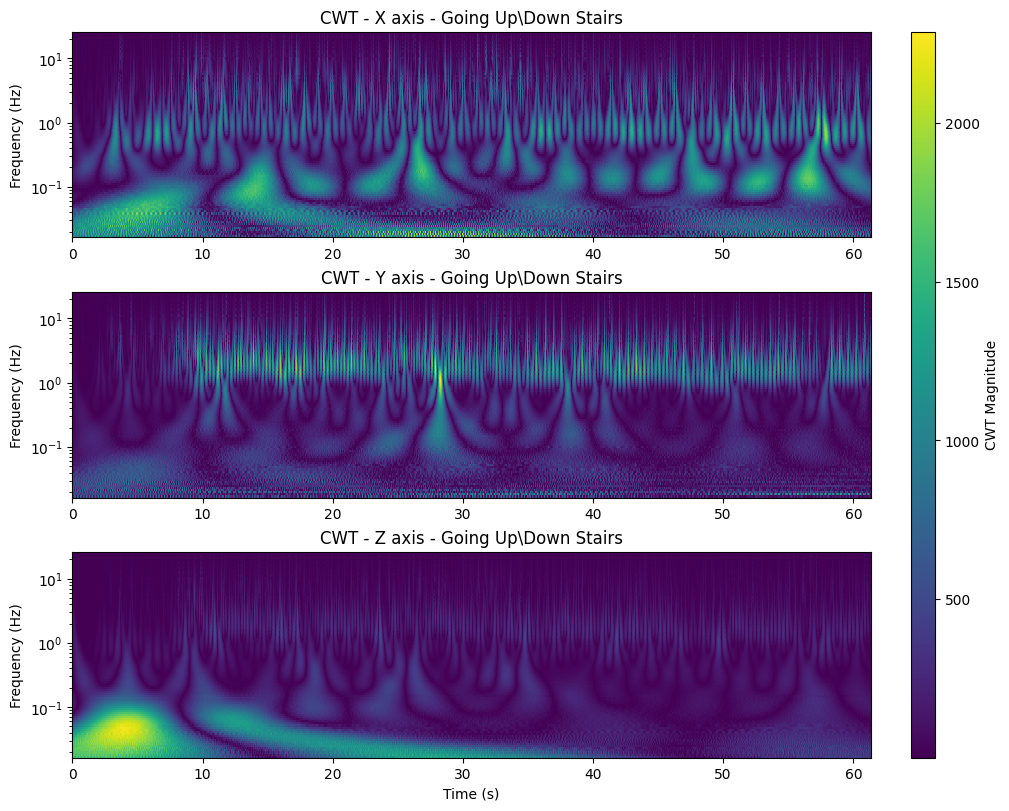

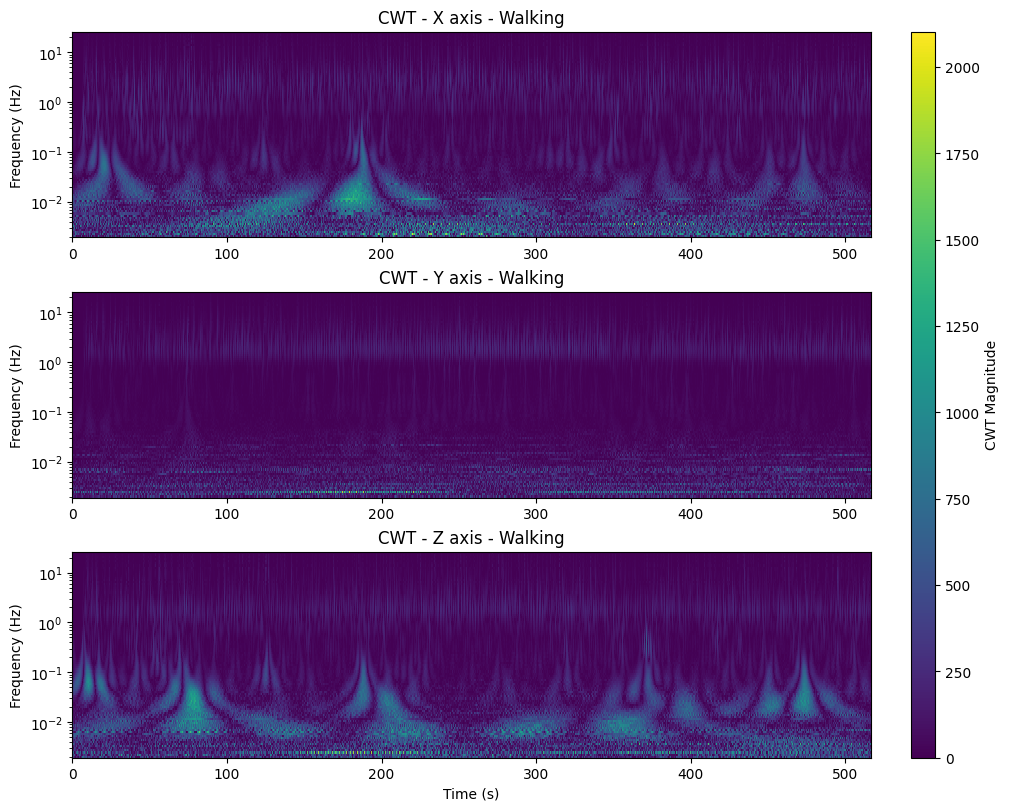

In [ ]:
activity = 'Going Up\\Down Stairs'
data = read_data(file_name, activity_labels[activity])
perform_cwt(data, title=activity)

activity = 'Walking'
data = read_data(file_name, activity_labels[activity])
perform_cwt(data, title=activity)
# exec time ~ 49s

#### Going Up/Down Stairs vs. Walking

These activities produce similar-looking plots. However, walking exhibits a less defined CWT structure and lower intensity, consistent with the greater variability and lower intensity of movements involved. Additionally, going up/down stairs generates strong vibrations periodically with each step. This periodicity is clearly visible at $\approx 10^{−1}$ Hz on the X channel as alternating blobs.

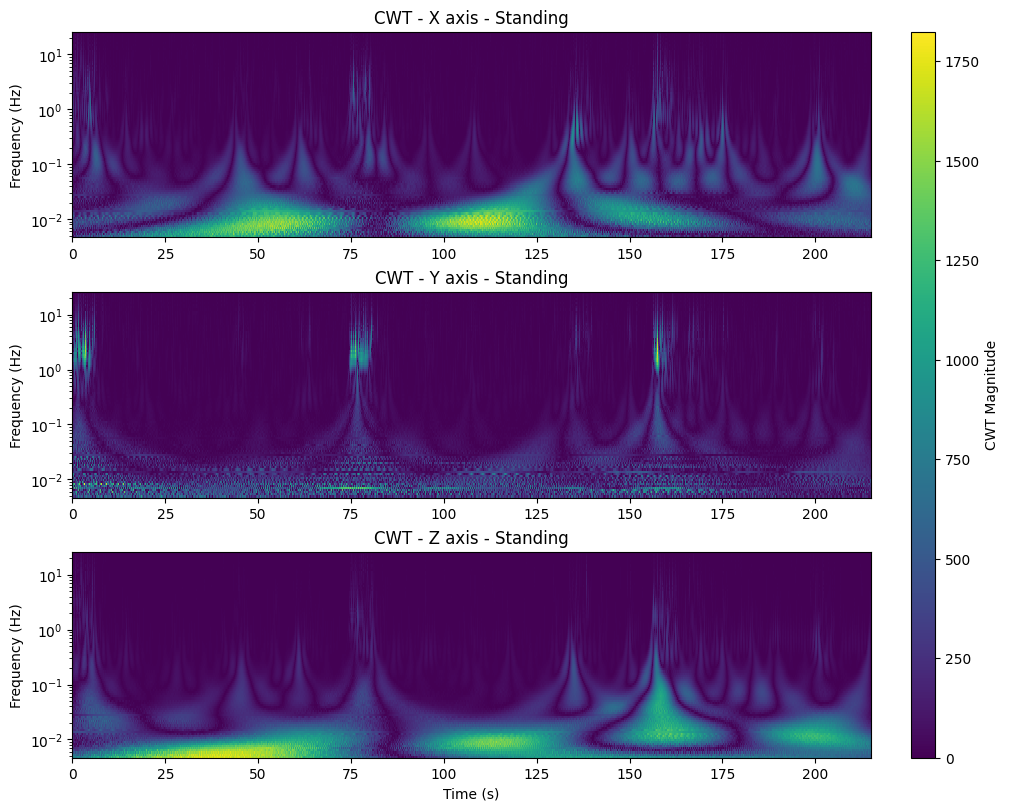

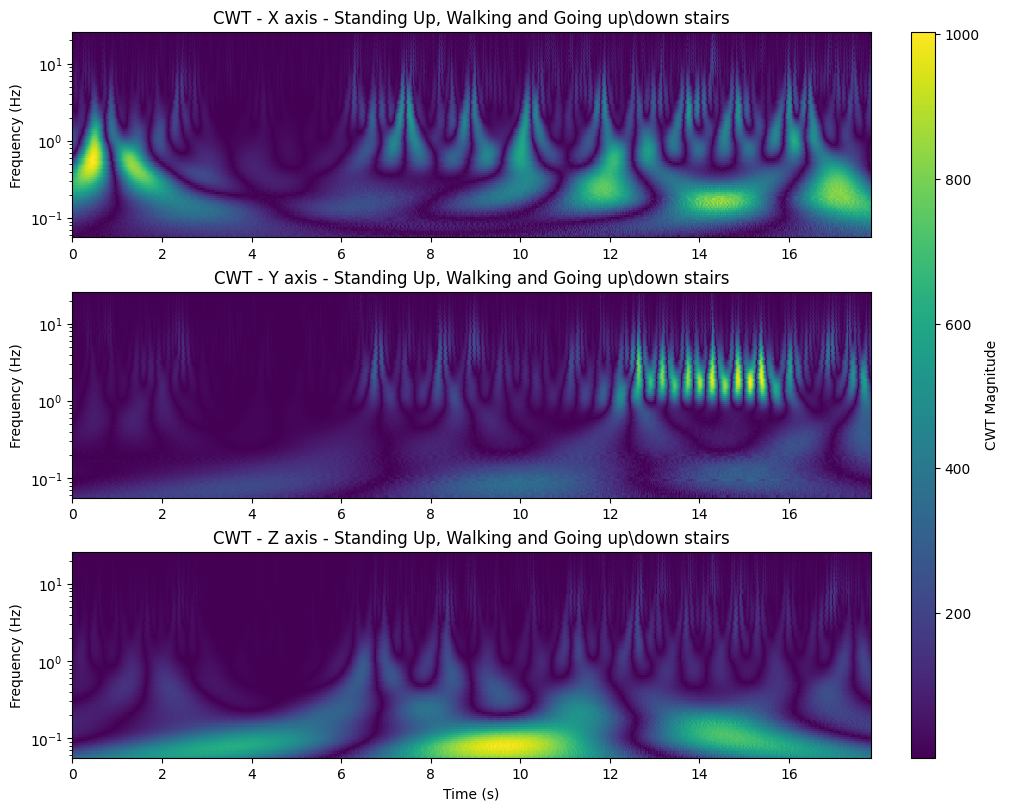

In [ ]:
activity = 'Standing'
data = read_data(file_name, activity_labels[activity])
perform_cwt(data, title=activity)

activity = 'Standing Up, Walking and Going up\\down stairs'
data = read_data(file_name, activity_labels[activity])
perform_cwt(data, title=activity)
# exec time ~ 13s

#### Standing vs. Standing Up, Walking, and Going Up/Down Stairs
"Standing" is characterized by CWTs with very low intensity and weak structures, reflecting the static nature of the activity. The frequencies involved are concentrated in the very low band, likely indicating micro-postural adjustments. In contrast, dynamic activities such as walking and going up/down stairs exhibit CWTs with significantly higher intensity and stronger structures, involving higher frequencies.

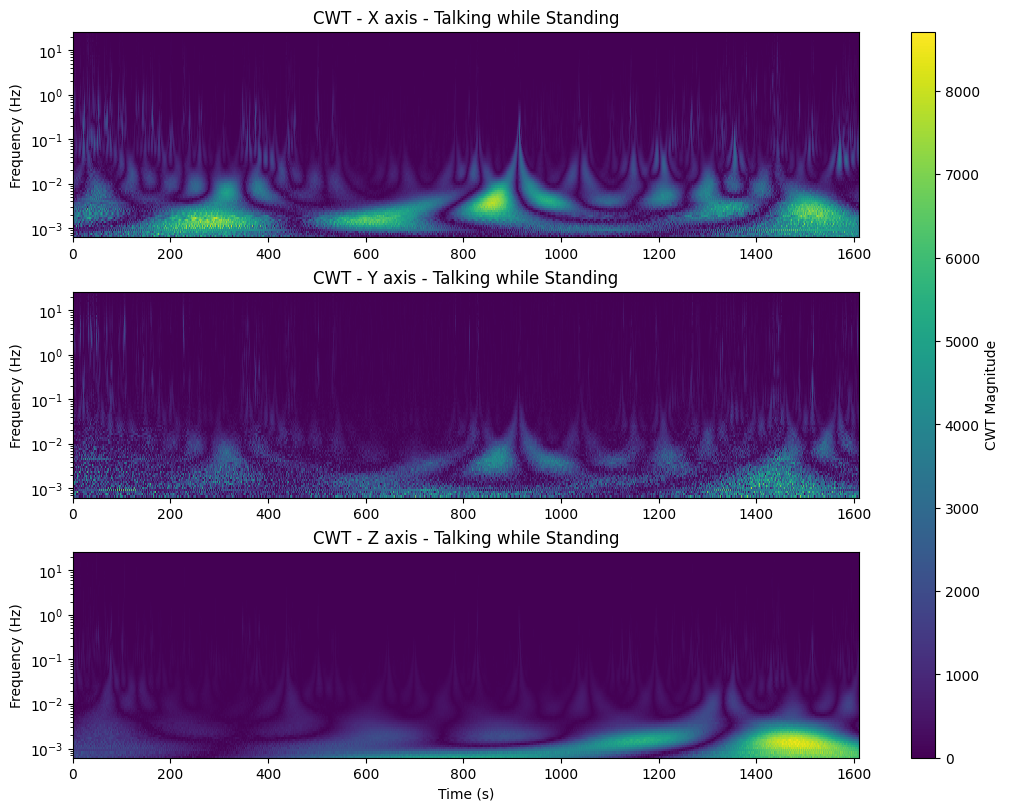

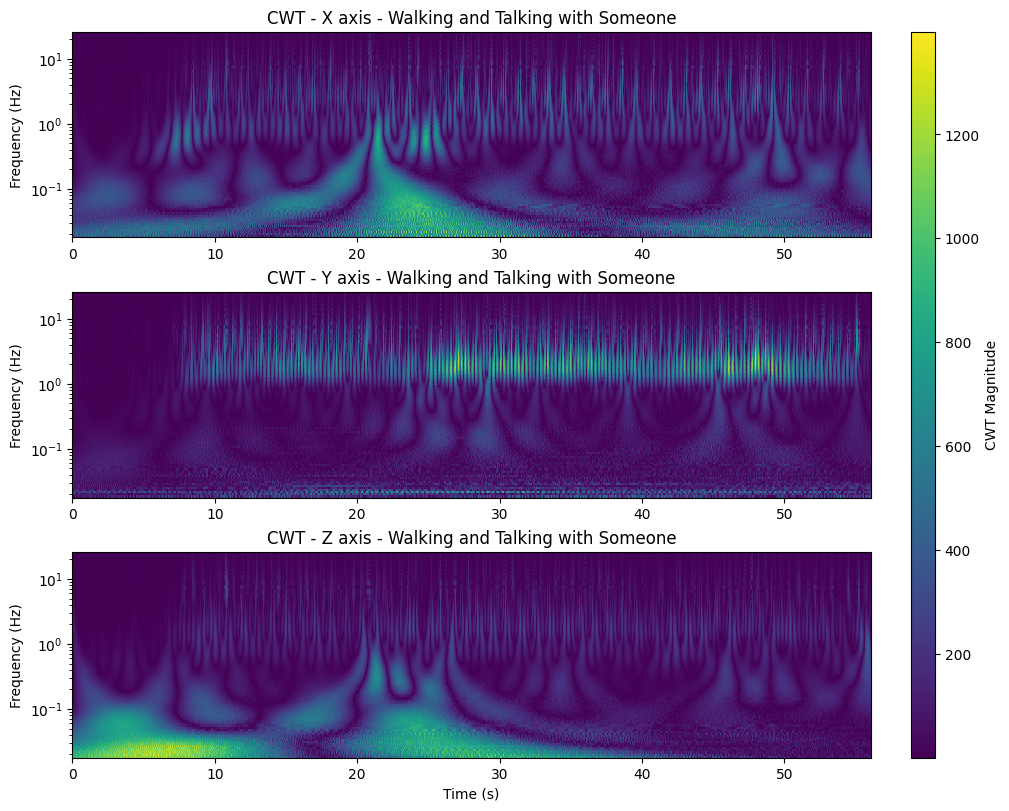

In [ ]:
activity = 'Talking while Standing'
data = read_data(file_name, activity_labels[activity])
perform_cwt(data, title=activity)

activity = 'Walking and Talking with Someone'
data = read_data(file_name, activity_labels[activity])
perform_cwt(data, title=activity)
# exec time ~ 6m 37s

#### Talking While Standing vs. Talking While Walking




"Talking while standing" shows CWTs similar to "standing," with a slight increase in intensity due to the movements associated with speaking. "Talking while walking" demonstrates a combination of characteristics from both walking and talking, featuring a more defined structure than simple walking. The structure of "talking while walking" is more defined than "talking while standing," attributable to the more regular movement pattern of walking.

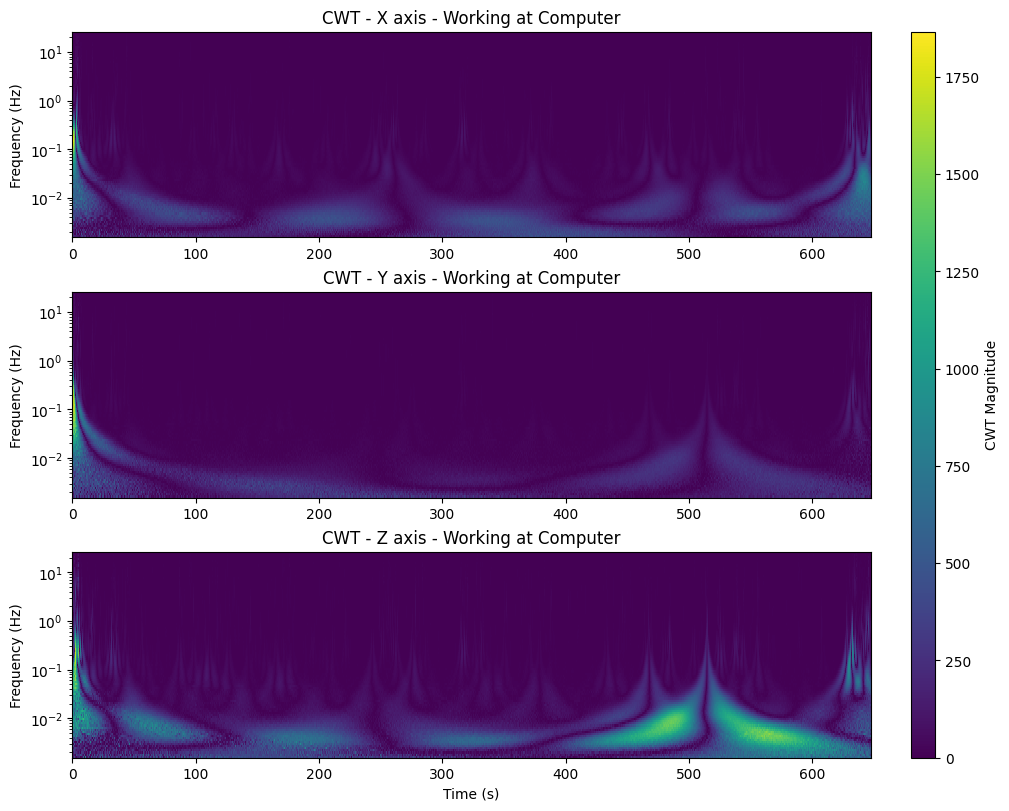

In [ ]:
activity = 'Working at Computer'
data = read_data(file_name, activity_labels[activity])
perform_cwt(data, title=activity)
# exec time ~ 1m 5s

### Working at computer

For completness I plotted also the last activity. A we can see the CWT show that only low frequencies are present. This is coherent with the activity that is mostly static.


The results obtained confirm the capability of the CWT to provide valuable insights into the dynamics of human movements.

To improve this activity recognition task, one idea is to train a neural network that takes the images generated by the CWT as input and classifies them.


